<a href="https://colab.research.google.com/github/M-Borsuk/LeafDiseasePrediction/blob/main/LeafDiseaseDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np 
import pandas as pd 
import os
import cv2
import seaborn as sns
from pylab import rcParams
import random as r
import shutil
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,load_model,Model
from keras.layers import Flatten,Dense,Dropout,BatchNormalization
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
import matplotlib.pyplot as plt


In [2]:
sns.set("paper","ticks")
sns.color_palette("tab10")
rcParams['figure.figsize'] = 16,8

In [3]:
!nvidia-smi

Wed Nov 25 09:10:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
main_dir = "/content/drive/MyDrive/leaf_disease_prediction"
train_dir = "/content/drive/MyDrive/leaf_disease_prediction/TRAIN"
submission_dir = "/content/drive/MyDrive/leaf_disease_prediction/SUBMISSION"

In [ ]:
#os.mkdir(os.path.join(main_dir,"TEST"))
#os.mkdir(os.path.join(main_dir,"VAL"))

In [5]:
test_dir = "/content/drive/MyDrive/leaf_disease_prediction/TEST"
val_dir = "/content/drive/MyDrive/leaf_disease_prediction/VAL"

In [6]:
y = pd.read_csv("/content/drive/MyDrive/leaf_disease_prediction/train.csv")
labels = pd.read_json('/content/drive/MyDrive/leaf_disease_prediction/label_num_to_disease_map.json',orient='index')
labels=labels.reset_index()

In [ ]:
#for l in [train_dir,test_dir,val_dir]:
#  for k in labels["Type"].values.tolist():
#    os.mkdir(os.path.join(l,k))

In [7]:
labels.columns = ["Label","Type"]

In [8]:
labels

,Label,Type
0,0,Cassava Bacterial Blight (CBB)
1,1,Cassava Brown Streak Disease (CBSD)
2,2,Cassava Green Mottle (CGM)
3,3,Cassava Mosaic Disease (CMD)
4,4,Healthy


In [9]:
y.shape

(21397, 2)

In [10]:
y = y.join(labels,on="label")
y.drop(columns="label",inplace=True)

In [11]:
y.shape

(21397, 3)

In [12]:
proportions = {z:np.round((x/y.shape[0]),2) for x,z in zip(y["Label"].value_counts().values,y["Label"].value_counts().index)}

In [13]:
proportions

{0: 0.05, 1: 0.1, 2: 0.11, 3: 0.61, 4: 0.12}

In [14]:
def move_images(source,y,dest,n):
  data = []
  ch = y.iloc[:,0].values.tolist()
  for i in range(n):
    r_jpg = r.choice(ch)
    ch.remove(r_jpg)
    temp = y[y["image_id"] == r_jpg].values.tolist()
    data.append(temp)
    y.drop(y[y["image_id"] == r_jpg].index,inplace=True)
    shutil.move(os.path.join(source,temp[0][0]),os.path.join(dest,temp[0][2]))
  return data

In [ ]:
#for file in os.listdir(val_dir):
#  shutil.move(os.path.join(val_dir,file),train_dir)

In [ ]:
y_val = move_images(train_dir,y,val_dir,int(21397 * 0.05))

In [ ]:
y_test = move_images(train_dir,y,test_dir,int(21397 * 0.1))

In [ ]:
y_train = move_images(train_dir,y,train_dir,len(y))

In [ ]:
y_val = np.array([y_val[i][0] for i in range(len(y_val))])

In [ ]:
y_test = np.array([y_test[i][0] for i in range(len(y_test))])

In [ ]:
y_train = np.array([y_train[i][0] for i in range(len(y_train))])

In [ ]:
y_val = pd.DataFrame(y_val,columns=["image","label","class"])

In [ ]:
y_test = pd.DataFrame(y_test,columns=["image","label","class"])

In [ ]:
y_train = pd.DataFrame(y_train,columns=["image","label","class"])

In [ ]:
temp=y_train["class"].value_counts().reset_index()

In [ ]:
temp.columns = ["Count","Type_of_disease"]

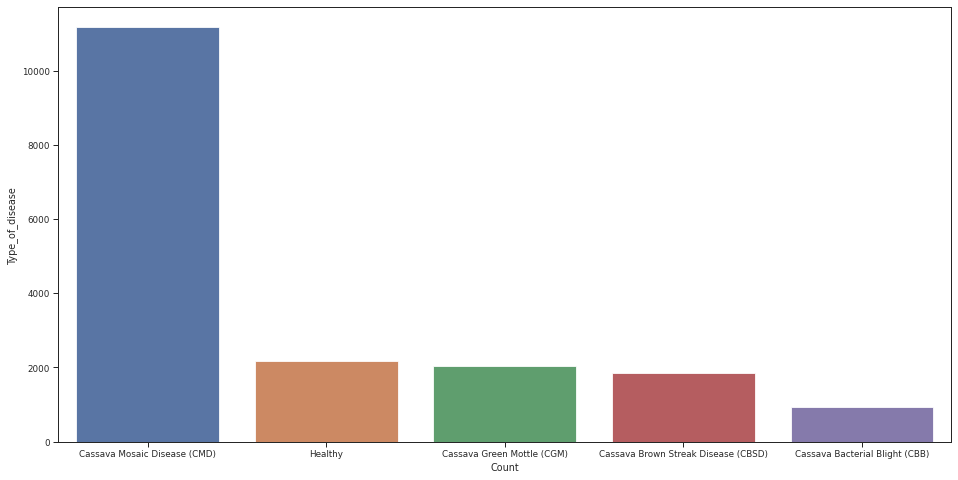

In [ ]:
sns.barplot(data=temp,x="Count",y="Type_of_disease")

In [ ]:
temp=y_test["class"].value_counts().reset_index()

In [ ]:
temp.columns = ["Count","Type_of_disease"]

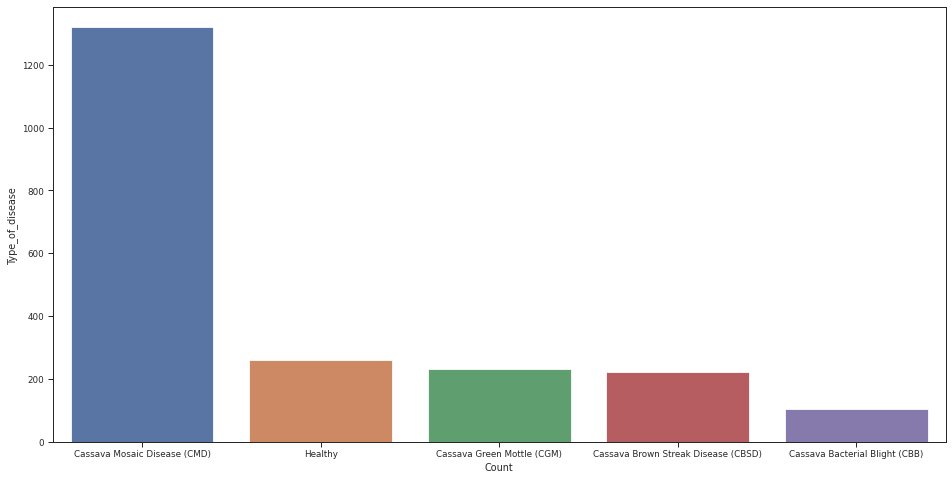

In [ ]:
sns.barplot(data=temp,x="Count",y="Type_of_disease")

In [ ]:
temp=y_val["class"].value_counts().reset_index()

In [ ]:
temp.columns = ["Count","Type_of_disease"]

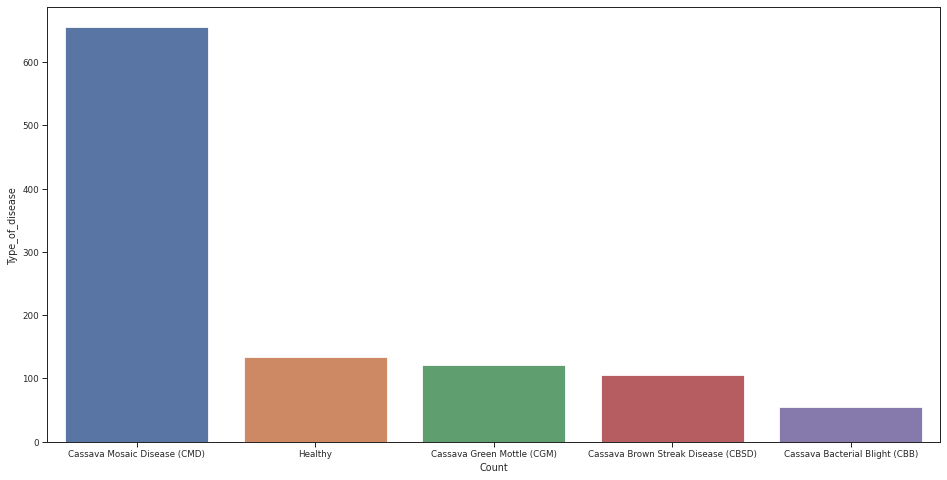

In [ ]:
sns.barplot(data=temp,x="Count",y="Type_of_disease")

In [ ]:
train_data_generator = ImageDataGenerator(
   width_shift_range=0.2,
   height_shift_range=0.2,
   rescale=1./255,
   zoom_range=0.1,
   vertical_flip = True)
val_data_generator = ImageDataGenerator(
   width_shift_range=0.2,
   height_shift_range=0.2,
   rescale=1./255,
   zoom_range=0.1,
   vertical_flip = True)
test_data_generator = ImageDataGenerator(rescale=1./255)
train_generator = train_data_generator.flow_from_directory(
        train_dir,
        target_size=(224,224),
        color_mode="rgb",
        batch_size=256)
validation_generator = val_data_generator.flow_from_directory(
        val_dir,
        color_mode="rgb",
        target_size=(224,224),
        batch_size=64)
test_generator = test_data_generator.flow_from_directory(
        test_dir,
        color_mode="rgb",
        target_size=(224,224),
        batch_size=128)


Found 18189 images belonging to 5 classes.
Found 1069 images belonging to 5 classes.
Found 2139 images belonging to 5 classes.


# **ResNet50**

In [ ]:
resnet = keras.applications.ResNet50(
    input_shape = (150,150,3),
    include_top = False
)

94773248/94765736 [==============================] - 5s 0us/step


In [ ]:
for layer in resnet.layers:
    layer.trainable = False

In [ ]:
for layer in resnet.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

In [ ]:
x = Flatten()(resnet.output)
x = Dense(1024,activation="elu", kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(5,activation="softmax")(x)
model = Model(inputs = resnet.input,outputs = x)

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)


In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
history = model.fit(train_generator ,epochs = 25, verbose = 1,validation_data=validation_generator,callbacks=[reduce_lr])

Epoch 1/25
  9/143 [>.............................] - ETA: 3:02:42 - loss: 47.2112 - accuracy: 0.4401

KeyboardInterrupt: ignored

# **Xception model**

In [ ]:
xception = keras.applications.Xception(
    weights='imagenet',  
    input_shape=(299,299, 3),
    include_top=True)

In [ ]:
for layer in xception.layers:
    layer.trainable = False

In [ ]:
for layer in xception.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

In [ ]:
x = Flatten()(xception.output)
x = Dense(1024,activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(5,activation="softmax")(x)
model = Model(inputs = xception.input,outputs = x)

In [ ]:
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)


In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
history = model.fit(train_generator ,epochs = 10, verbose = 1,validation_data=validation_generator,callbacks=[reduce_lr])

# **Inception**

In [ ]:
inception = InceptionV3(input_shape=(224,224,3), weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 4s 0us/step


In [ ]:
for layer in inception.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(inception.output)
x = Dense(1024,activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(5,activation="softmax")(x)
model = Model(inputs = inception.input,outputs = x)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
             EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
history = model.fit(train_generator ,epochs = 10, verbose = 1,validation_data=validation_generator,callbacks=[reduce_lr])

Epoch 1/10
72/72 [==============================] - 10564s 147s/step - loss: 1.2490 - accuracy: 0.5683 - val_loss: 1.0284 - val_accuracy: 0.6473
Epoch 2/10
72/72 [==============================] - 412s 6s/step - loss: 0.9595 - accuracy: 0.6559 - val_loss: 0.8739 - val_accuracy: 0.6791
Epoch 3/10
72/72 [==============================] - 408s 6s/step - loss: 0.9018 - accuracy: 0.6729 - val_loss: 0.8871 - val_accuracy: 0.6810
Epoch 4/10
72/72 [==============================] - 405s 6s/step - loss: 0.8802 - accuracy: 0.6795 - val_loss: 0.8358 - val_accuracy: 0.6922
Epoch 5/10
72/72 [==============================] - 405s 6s/step - loss: 0.8591 - accuracy: 0.6860 - val_loss: 0.8300 - val_accuracy: 0.6941
Epoch 6/10
72/72 [==============================] - 406s 6s/step - loss: 0.8505 - accuracy: 0.6868 - val_loss: 0.8744 - val_accuracy: 0.6922
Epoch 7/10
72/72 [==============================] - 408s 6s/step - loss: 0.8397 - accuracy: 0.6956 - val_loss: 0.8450 - val_accuracy: 0.6922
Epoch 8/1

In [ ]:
model.evaluate(train_generator)

72/72 [==============================] - 385s 5s/step - loss: 0.7880 - accuracy: 0.7095


[0.7879513502120972, 0.7095497250556946]

In [ ]:
model.save(os.path.join(main_dir,"saved_inc_model.h5"))

In [17]:
model = load_model(os.path.join(main_dir,"saved_inc_model.h5"))

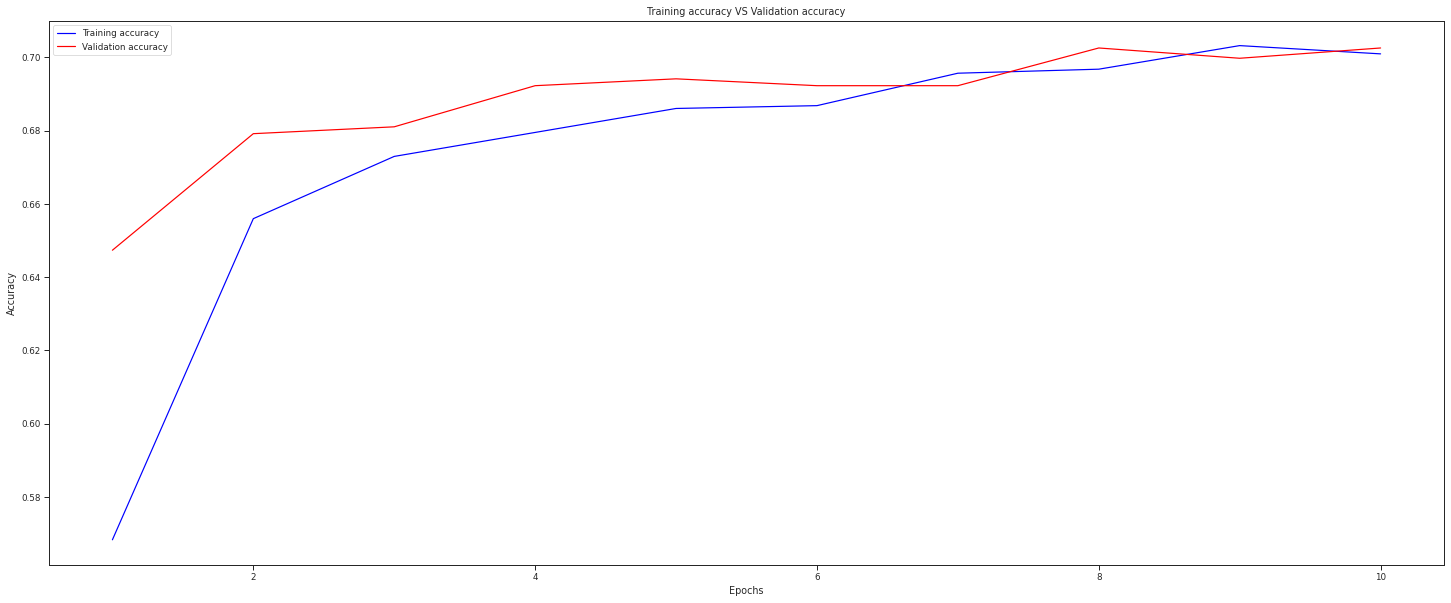

In [ ]:
plt.figure(figsize=(25,10))
plt.plot(range(1,11),history.history['accuracy'],color="blue", label="Training accuracy", linestyle="-")
plt.plot(range(1,11),history.history['val_accuracy'],color="red", label="Validation accuracy", linestyle="-")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training accuracy VS Validation accuracy")
plt.legend()
plt.show()

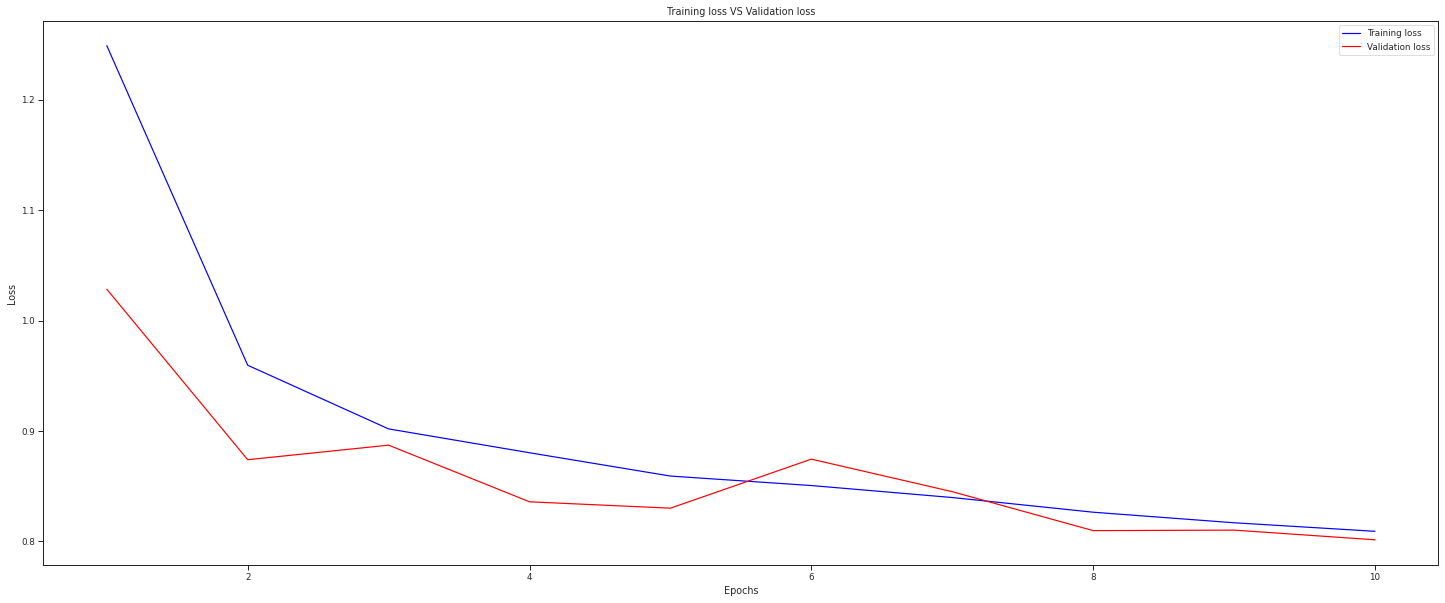

In [ ]:
plt.figure(figsize=(25,10))
plt.plot(range(1,11),history.history['loss'],color="blue", label="Training loss", linestyle="-")
plt.plot(range(1,11),history.history['val_loss'],color="red", label="Validation loss", linestyle="-")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Training loss VS Validation loss")
plt.legend()
plt.show()

In [22]:
img_arr = cv2.imread(os.path.join(submission_dir, '2216849948.jpg'), cv2.IMREAD_COLOR)
resized_arr = cv2.resize(img_arr, (224,224)) 

In [23]:
X_test = resized_arr / 255.

In [24]:
X_test = X_test.reshape(-1,224,224,3)

In [26]:
y_pred = model.predict(X_test)

In [27]:
y_pred

array([[0.01989304, 0.04152151, 0.20554216, 0.5506335 , 0.1824098 ]],
      dtype=float32)